<a href="https://colab.research.google.com/github/yuruojie777/NLP/blob/main/COMP5046_Lab07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 07 Dependency parsing


## Dependency Parsing Exercise

Let's parse the following sentence! (Use your skill that you learned in the lecture)

*  I prefer the morning flight through Denver


Do this parsing exercise and ***check with the answer (at the end of this Lab07 material)***


**Dependency parsing process:** (Need more detailed parsing steps? Please watch the Lecture 7 recording!)



## Off-the-Shelf Tool (Spacy Parser)
Now let's use [spaCy](https://spacy.io/) to automatically parse sentences.
The spaCy parser was developed based on a neural network based parser.

Parse the sentence ***'The woman showed a wellshaped smile in the dark.'***


In [6]:
import spacy
#PrettyTable is a Python library for generating attractive ASCII tables.
from prettytable import PrettyTable

#load the spacy api with the pre-trained statistical models for English. English multi-task CNN trained on the OntoNotes corpus
nlp = spacy.load("en_core_web_sm")

#define the sentence
sentence = "The woman showed a wellshaped smile in the dark."
parse = nlp(sentence)

x = PrettyTable()
#define column names
x.field_names = ["TokenID", "Token", "HeadID", "Dependency"]

#spaCy does not provide the fake ROOT token so add a row for the fake Root
x.add_row([0,"ROOT",0,"-"])

#parsing recursively
for token in parse:
  if token.dep_=="ROOT":
    x.add_row([token.i+1,token.text,"0",token.dep_])
  else:  
    x.add_row([token.i+1,token.text,token.head.i+1,token.dep_])
    
print("Parsing Result with Spacy API")
#printing the table
print(x)

Parsing Result with Spacy API
+---------+------------+--------+------------+
| TokenID |   Token    | HeadID | Dependency |
+---------+------------+--------+------------+
|    0    |    ROOT    |   0    |     -      |
|    1    |    The     |   2    |    det     |
|    2    |   woman    |   3    |   nsubj    |
|    3    |   showed   |   0    |    ROOT    |
|    4    |     a      |   6    |    det     |
|    5    | wellshaped |   6    |    amod    |
|    6    |   smile    |   3    |    dobj    |
|    7    |     in     |   3    |    prep    |
|    8    |    the     |   9    |    det     |
|    9    |    dark    |   7    |    pobj    |
|    10   |     .      |   3    |   punct    |
+---------+------------+--------+------------+


## Parsing Visualisation
Spacy provides its built-in visualisation suite, [displaCy](https://spacy.io/api/top-level#displacy)

In [7]:
#spaCy comes with a built-in visualisation suite
from spacy import displacy

doc = nlp(sentence)
displacy.render(doc, style='dep', jupyter=True, options={'distance':90})


Unfortunately, the parsing result is ***NOT*** perfect. 
The result shows that *the head of the token '**dark**' is 'in' rather than 'showed'*.


### How can we evaluate the parsing result?

[Universal Dependencies](http://universaldependencies.org/) is such a grammatical annotation effort. Basiclly, a bunch of linguists sit there to manually label 'which head is this token modifying' or 'which syntactic role is this token playing with respect to which predicate'. We call their annotations ground truth, and evaluate outputs from different systems against this ground truth. The higher accuracy the system achieves, the better this system is.

## Parsing Evaluation (with Universal Dependencies)

The following code shows the function for evaluating the performance of spaCy parser with Universal Dependencies.


*   [CoNLL-U formatted by Universal Dependencies](http://universaldependencies.org/format.html)



In [8]:
#CoNLL-U Parser parses a CoNLL-U formatted string into a nested python dictionary. 
!pip install conllu

Let's make a function for evaluation of the parsing result

In [9]:
import numpy as np
import conllu as conllu
from conllu import parse

#text: the text that you would like to parse
#gold: the gold-standard annotation for the text
def evaluate_sentence_parsing(text, gold):
  #parse the text with spaCy API
  parse = nlp(text)
  #setup the table for the parsing result table
  x = PrettyTable()
  x.field_names = ["TokenID", "Token", "HeadID", "Dependency"]
  x.add_row([0,"root",0,"-"])

  for token in parse:
    if token.dep_=="ROOT":
      x.add_row([token.i+1,token.text,"0","root"])
      token.dep_="root"
    else:  
      x.add_row([token.i+1,token.text,token.head.i+1,token.dep_])
 
  #printing the parsing result
  print("Parsing Result with Spacy API")
  print(x)
  
  #setup the table for the parsing result table
  y = PrettyTable()
  y.field_names = ["TokenID", "Token", "HeadID", "Dependency"]
  y.add_row([0,"root",0,"-"])

  #parse the gold-standard with conll-u parser 
  sentences = conllu.parse(gold)
  sentence = sentences[0]

  for token in sentence:
    if token['deprel']=="root":
      y.add_row([token['id'],token['form'],"0",token['deprel']])
    else:  
      y.add_row([token['id'],token['form'],token['head'],token['deprel']])
  print("Gold-Standard Annotation")
  print(y)

  #summarise the list of predicted head
  pred_head = [t.head.i+1 if i != t.head.i else 0 for i, t in enumerate(parse)]
  #summarise the list of gold head
  gold_head = [token['head'] for i, token in enumerate(sentence)]
  
  #summarise the list of predicted dependency relations
  pred_dep = [t.dep_ for i, t in enumerate(parse)]
  #summarise the list of gold dependency relations
  gold_dep = [token['deprel'] for i, token in enumerate(sentence)] 
  
  print("\n\nParsing Result vs Gold - Head")
  print(pred_head)
  print(gold_head)

  print("\n\nParsing Result vs Gold - Dependency")
  print(pred_dep)
  print(gold_dep)
  
  #performance evaluation - Unlabeled Attachment Score (UAS)
  #Unlabeled Attachment Score (UAS): the percent of words that have the correct heads
  uas_accuracy = np.sum([1 if g == p else 0 for g, p in zip(gold_head, pred_head)]) / len(gold_head)
  
  
  print("\n\nUnlabeled Attachment Score (UAS)")
  return uas_accuracy  

With the above function, let's try to test and evaluate it.
There are two evaluation metrics:
1. **Unlabeled Attachment Score (UAS)**: the percent of words that have the correct heads
2. **Labeled Attachment Score (LAS)**: the percent of words that have the correct heads and labels 



In [29]:
#testing sentence
text = "The woman showed a wellshaped smile in the dark."

#gold-standard of the sentence
gold = """
# text = The woman showed a wellshaped smile in the dark.
1	The	the	DET	DEF	Definite=Def|PronType=Art	2	det	_	_
2	woman	woman	NOUN	SG-NOM	Number=Sing	3	nsubj	_	_
3	showed	show	VERB	PAST	Mood=Ind|Tense=Past|VerbForm=Fin  0	root	_	_
4	a	a	DET	IND-SG	Definite=Ind|PronType=Art	6	det	_	_
5	wellshaped	wellshaped	ADJ	POS	Degree=Pos	6	amod	_	_
6	smile	smile	NOUN	SG-NOM	Case=Nom	3	obj	_	_
7	in	in	ADP	_	_	9	prep _ _
8	the	the	DET	DEF	Definite=Def|PronType=Art	9	det	_	_
9	dark	dark	ADJ	POS	Degree=Pos	3	obl	_	SpaceAfter=No
10	.	.	PUNCT	Period	_	3	punct	_	_


"""

print(evaluate_sentence_parsing(text, gold))

Parsing Result with Spacy API
+---------+------------+--------+------------+
| TokenID |   Token    | HeadID | Dependency |
+---------+------------+--------+------------+
|    0    |    root    |   0    |     -      |
|    1    |    The     |   2    |    det     |
|    2    |   woman    |   3    |   nsubj    |
|    3    |   showed   |   0    |    root    |
|    4    |     a      |   6    |    det     |
|    5    | wellshaped |   6    |    amod    |
|    6    |   smile    |   3    |    dobj    |
|    7    |     in     |   3    |    prep    |
|    8    |    the     |   9    |    det     |
|    9    |    dark    |   7    |    pobj    |
|    10   |     .      |   3    |   punct    |
+---------+------------+--------+------------+
Gold-Standard Annotation
+---------+------------+--------+------------+
| TokenID |   Token    | HeadID | Dependency |
+---------+------------+--------+------------+
|    0    |    root    |   0    |     -      |
|    1    |    The     |   2    |    det     |
|    

###Summary
The result shows that the UAS is 0.8. 

It means that there are 2 incorrectly predicted heads out of 10. 
1.   The gold head of token 'in' is 'dark', whereas the prediction is 'smile'
2.   The gold head of token 'dark' is 'showed', whereas the prediction is 'in'.

**UAS** is the percent of words that have the correct heads

**LAS** is the percent of words that have the correct heads and labels.


---



## Transition-based Dependency Parser

The Transition-based Dependency Parser is a simple form of a greedy discriminative dependency parser. It builds only one tree, in one left-to-right sweep over the input


The transition-based model consists of:
*   a ***buffer***, for storing unprocessed text. At the very beginning, it stores the input tokens
*   a ***stack***, for storing elements being processed. By default, it always has the ROOT token.
*   a list of ***dependency relations***, you can also consider this as the parsing results. Tt is usually a list of tuples, each of which is a token and its head.

The ***arc-standard*** algorithm has three actions which can be applied to change the states of buffer, stack and dependency relation list:

*   **LEFTARC**: assert a head-dependent relation between the word at the top of the stack and the word directly beneath it; remove the lower word from the stack.
*   **RIGHTARC**: assert a head-dependent relation between the second word on the stack and the word at the top; remove the word at the top of the stack; 
*   **SHIFT**: remove the word from the front of the input buffer and push it onto the stack. 

####Lecture 7 - slide 52
![alt text](https://drive.google.com/uc?export=view&id=1S09VzsLhwwBJadtUmOyrb5_gYRQMsBWs)



In [ ]:
class Parse(object):
    def __init__(self, sentence):
        self.sentence = sentence
        self.stack = ["<ROOT>"]
        self.buffer = sentence.split()
        self.relations = []

   #transition setup
    def parse_step(self, action):
        assert action in ["SHIFT", "LEFTARC", "RIGHTARC"]
        if action == "SHIFT":
            assert len(self.buffer) > 0
            token = self.buffer.pop(0)
            self.stack.append(token)
        else:
            assert len(self.stack) >= 2
            if action == "LEFTARC":
                relation = (self.stack[-1], self.stack[-2])
                self.relations.append(relation)
                self.stack.pop(-2)
            else:
                relation = (self.stack[-2], self.stack[-1])
                self.relations.append(relation)
                self.stack.pop(-1)

    def parse(self, actions):
        print("Let's start:")
        output_parse_state(self)
        print("*" * 50)
        for action in actions:
            self.parse_step(action)
            print("after action:", action)
            output_parse_state(self)
            print("*" * 50)


def output_parse_state(parse):
    print("Stack:", " ".join(parse.stack))
    print("Buffer:", " ".join(parse.buffer))
    print("Relations:")
    for relation in parse.relations:
        print("  %s -> %s" % (relation[0], relation[1]))

In [ ]:
sentence = "Book me the morning flight"

actions = ["SHIFT", "SHIFT", "RIGHTARC", "SHIFT", "SHIFT", "SHIFT", "LEFTARC", 
           "LEFTARC", "RIGHTARC", "RIGHTARC"]
           
parse_obj = Parse(sentence)
parse_obj.parse(actions)

Let's start:
Stack: <ROOT>
Buffer: Book me the morning flight
Relations:
**************************************************
after action: SHIFT
Stack: <ROOT> Book
Buffer: me the morning flight
Relations:
**************************************************
after action: SHIFT
Stack: <ROOT> Book me
Buffer: the morning flight
Relations:
**************************************************
after action: RIGHTARC
Stack: <ROOT> Book
Buffer: the morning flight
Relations:
  Book -> me
**************************************************
after action: SHIFT
Stack: <ROOT> Book the
Buffer: morning flight
Relations:
  Book -> me
**************************************************
after action: SHIFT
Stack: <ROOT> Book the morning
Buffer: flight
Relations:
  Book -> me
**************************************************
after action: SHIFT
Stack: <ROOT> Book the morning flight
Buffer: 
Relations:
  Book -> me
**************************************************
after action: LEFTARC
Stack: <ROOT> Book the f

###Discussion
Where does this list of actions come from? It looks magic, but how can I know what actions to apply? A classifier is trained to predict what the next action is given the current state.
This machine learning classifier takes the state of buffer, stack, previous list of relations as input, and predict what the next action is. 

For more details, please read ***Lecture 7 from slide 69***

# Exercise

## E1. Multiple Choice Questions
***Please check the following Ed Q Link.*** We have two MCQ Questions (0.5 marks for each Q). If you answer only one question correctly, you will receive 0.5 out of 1.

E1 (Ed Q Link): https://edstem.org/au/courses/7951/lessons/21122/slides/149971



---



##E2. Spacy Parser Practice
Evaluate the spaCy model using Universal Dependencies annotations (You should provide the parsing performance with a metric: **UAS** - We introduced in Lecture 7, please refer to page 73-75)

You are going to write a function which uses the index of a sentence as input and return the **UAS** of the output from using the spaCy model, you should also **visualise the parsing graph** from the spaCy model.





In [1]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1vktZbQ_yjvUqTyf0qBhkRsyvDnK0ueMe'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('en_lines-ud-test.conllu')  

!pip install conllu
from io import open
from conllu import parse_incr
import spacy
import numpy as np
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
data_file = open("en_lines-ud-test.conllu", "r", encoding="utf-8")

sent_list = []
gold_head_list = []
gold_label_list = []
n = 0
 
for tokenlist in parse_incr(data_file):
    n += 1
    if n > 20:
        break

    sent = tokenlist.metadata['text']
    gold_head = [token['head'] for i, token in enumerate(tokenlist)]    
    gold_label = [token['deprel'] for i, token in enumerate(tokenlist)]
    sent_list.append(sent)
    gold_head_list.append(gold_head)
    gold_label_list.append(gold_label)

print(sent_list[1])
print(gold_head_list[1])
print(gold_label_list[1])

This type of drop area is not displayed for single charts.
[2, 8, 5, 5, 2, 8, 8, 0, 11, 11, 8, 8]
['det', 'nsubj:pass', 'case', 'compound', 'nmod', 'aux:pass', 'advmod', 'root', 'case', 'amod', 'obl', 'punct']


**Note:** Please DO NOT change the code outside of the parse_UAS function

In [46]:
gold = """
# text = This type of drop area is not displayed for single charts.
1  This  this  DET	 DEF  _  2  det  _  _ 
2  type type	NOUN _ _ 8 nsubj:pass _ _ 
3  of of	ADP _ _ 2 prep _ _  
4  drop drop	NOUN _ _ 5 compound _ _ 
5  area area	NOUN _ _ 3 nmod _ _ 
6  is is	AUX _ _ 8 aux:pass _ _                 
7  not not	PART _ _ 8 advmod _ _  
8  displayed display VERB PAST	Mood=Ind|Tense=Past|VerbForm=Fin 0 root _ _               
9  for for ADP _ _ 8 case _ _  
10  single single ADJ _ _ 11 amod _ _  
11  charts chart NOUN _ _ 9 obl _ _  
12  . . PUNCT Period _ 8 punct _	_ 


"""

def parse_UAS(index_sent):
    sent = sent_list[index_sent]
    gold_head = gold_head_list[index_sent]
    #parse the text with spaCy API
    parse = nlp(text)
    #setup the table for the parsing result table
    x = PrettyTable()
    x.field_names = ["TokenID", "Token", "HeadID", "Dependency"]
    x.add_row([0,"root",0,"-"])

    for token in parse:
      if token.dep_=="ROOT":
        x.add_row([token.i+1,token.text,"0","root"])
        token.dep_="root"
      else:  
        x.add_row([token.i+1,token.text,token.head.i+1,token.dep_])
  
    #printing the parsing result
    print("Parsing Result with Spacy API")
    print(x)
    
    #setup the table for the parsing result table
    y = PrettyTable()
    y.field_names = ["TokenID", "Token", "HeadID", "Dependency"]
    y.add_row([0,"root",0,"-"])

    #parse the gold-standard with conll-u parser 
    sentences = conllu.parse(gold)
    sentence = sentences[0]

    for token in sentence:
      if token['deprel']=="root":
        y.add_row([token['id'],token['form'],"0",token['deprel']])
      else:  
        y.add_row([token['id'],token['form'],token['head'],token['deprel']])
    print("Gold-Standard Annotation")
    print(y)

    #summarise the list of predicted head
    pred_head = [t.head.i+1 if i != t.head.i else 0 for i, t in enumerate(parse)]
    #summarise the list of gold head
    gold_head = [token['head'] for i, token in enumerate(sentence)]
    
    #summarise the list of predicted dependency relations
    pred_dep = [t.dep_ for i, t in enumerate(parse)]
    #summarise the list of gold dependency relations
    gold_dep = [token['deprel'] for i, token in enumerate(sentence)] 
    
    print("\n\nParsing Result vs Gold - Head")
    print(pred_head)
    print(gold_head)

    print("\n\nParsing Result vs Gold - Dependency")
    print(pred_dep)
    print(gold_dep)
    
    #performance evaluation - Unlabeled Attachment Score (UAS)
    #Unlabeled Attachment Score (UAS): the percent of words that have the correct heads
    uas_accuracy = np.sum([1 if g == p else 0 for g, p in zip(gold_head, pred_head)]) / len(gold_head)
    
    
    print("\n\nUnlabeled Attachment Score (UAS)") 

    # Please complete this part
    return sentences, uas_accuracy


parsed, UAS = parse_UAS(1)
print("UAS: {0:.4f}".format(UAS))
displacy.render(parsed, style='dep', jupyter=True, options={'distance':90})

Parsing Result with Spacy API
+---------+------------+--------+------------+
| TokenID |   Token    | HeadID | Dependency |
+---------+------------+--------+------------+
|    0    |    root    |   0    |     -      |
|    1    |    The     |   2    |    det     |
|    2    |   woman    |   3    |   nsubj    |
|    3    |   showed   |   0    |    root    |
|    4    |     a      |   6    |    det     |
|    5    | wellshaped |   6    |    amod    |
|    6    |   smile    |   3    |    dobj    |
|    7    |     in     |   3    |    prep    |
|    8    |    the     |   9    |    det     |
|    9    |    dark    |   7    |    pobj    |
|    10   |     .      |   3    |   punct    |
+---------+------------+--------+------------+


KeyError: ignored

E2 Sample output (Only for format reference)
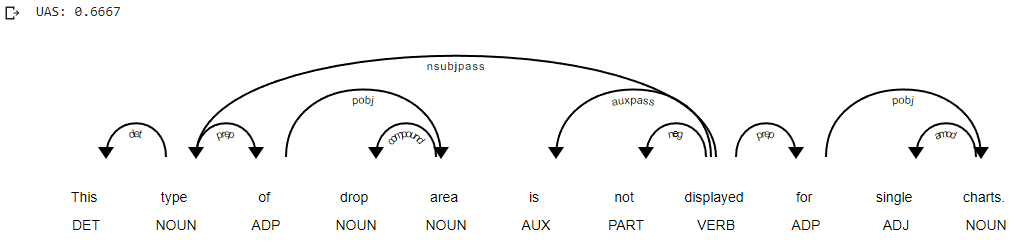

# Dependency Parsing Answer

![alt text](https://www.researchgate.net/publication/334216098/figure/fig4/AS:776769690951681@1562207734172/A-sentence-in-dependency-format-Source-19-p-245.jpg)